In [2]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
import matplotlib.pyplot as plt
sns.set()

### Using term frequency of n-grams across tv shows (with pre-defined vocabulary)

In [13]:
client = bigquery.Client()

query=f"""
select *
from goldenfleece.final_task.tv_1grams_monthly
order by DATE
"""
document_df = client.query(query).to_dataframe()
document_df.head(3)

,DATE,NGRAM,COUNT
0,2009-07-01,ha,2.760000
1,2009-07-01,no,26.370614
2,2009-07-01,ass,1.500000


In [15]:
document_df = document_df.astype({"DATE":"datetime64"}) 
document_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781379 entries, 0 to 781378
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   DATE    781379 non-null  datetime64[ns]
 1   NGRAM   781379 non-null  object        
 2   COUNT   781379 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 60.6 MB


In [21]:
document_df.DATE.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  781379
unique                    138
top       2016-06-01 00:00:00
freq                     6023
first     2009-07-01 00:00:00
last      2020-12-01 00:00:00
Name: DATE, dtype: object

In [17]:
tf_df = pd.pivot_table(document_df, values="COUNT", index="DATE", columns="NGRAM", aggfunc=np.mean, fill_value=0)

In [18]:
tf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 2009-07-01 to 2020-12-01
Columns: 7247 entries, 144a to zone
dtypes: float64(6688), int64(559)
memory usage: 7.6 MB


In [23]:
query=f"""
SELECT DATE, GDP from
goldenfleece.final_task.monthly_gdp_lag 
where DATE >= '2009-06-01'
order by DATE
"""
gdp_df = client.query(query).to_dataframe()
gdp_df.head()

,DATE,GDP
0,2009-06-01,-0.2
1,2009-07-01,-0.1
2,2009-08-01,0.2
3,2009-09-01,0.2
4,2009-10-01,0.2


In [24]:
gdp_df = gdp_df.astype({"DATE":"datetime64"}).set_index("DATE")
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136 entries, 2009-06-01 to 2020-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     136 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [25]:
# reset index to set DATE as column
combined_df = tf_df.merge(gdp_df, left_index=True, right_index=True, how="right").reset_index()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Columns: 7249 entries, DATE to GDP
dtypes: datetime64[ns](1), float64(7248)
memory usage: 7.5 MB


In [26]:
from cross_validate import cross_validate, build_design_matrix, evaluate_features

### Check stationarity assumption

From visual inspection, exclude COVID period to satisfy stationarity assumption

In [33]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

estimator=LinearRegression()
# estimator=Ridge()
# estimator=Lasso()
# estimator=DecisionTreeRegressor(random_state=0)

rmse_list = []
design_df_list = []
result_df_list = []
for horizon in [1,2,3,4,5,6]:
    design_df, result_df = evaluate_features(
        combined_df,
        date_col="DATE",
        var_col="GDP",
        horizon=horizon,
        estimator=estimator,
        window=36,
        period=1,
        return_model=True,
        start_date="2009-07-01",
        end_date="2020-03-01",
    )
    rmse = (((result_df["pred"] - result_df["actual"]) ** 2).mean()) ** 0.5
    rmse_list.append(rmse)
    design_df_list.append(design_df)
    result_df_list.append(result_df)
    print(f"Average RMSE over {len(result_df)} predictions for {horizon}-month horizon: {rmse:.3f}")

print(f"\nAverage RMSE across different horizons: {np.array(rmse_list).mean():.3f}")

Average RMSE over 90 predictions for 1-month horizon: 0.385
Average RMSE over 88 predictions for 2-month horizon: 0.388
Average RMSE over 86 predictions for 3-month horizon: 0.380
Average RMSE over 84 predictions for 4-month horizon: 0.386
Average RMSE over 82 predictions for 5-month horizon: 0.394
Average RMSE over 80 predictions for 6-month horizon: 0.410

Average RMSE across different horizons: 0.391


<AxesSubplot:xlabel='date'>

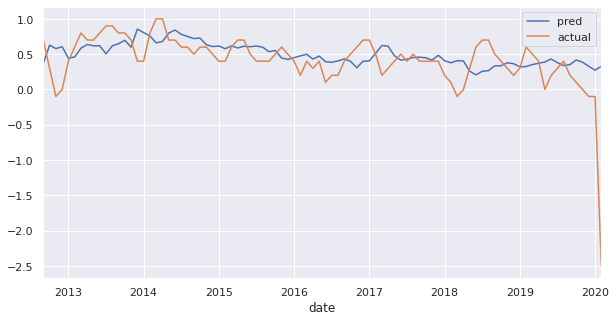

In [34]:
# check 1-month horizon plot
result_df = result_df_list[0]
result_df[["pred", "actual", "date"]].set_index("date").plot(figsize=(10,5))